<a href="https://colab.research.google.com/github/David-gutierrez-rodriguez/Simulacion-I/blob/main/Bayesian_Missing_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal

In [ ]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

In [ ]:
try:
    df_employee = pd.read_csv("../data/employee.csv")
except FileNotFoundError:
    df_employee = pd.read_csv(pm.get_data("employee.csv"))
# df_employee.head(9)

df_employee

,employee,team,turnover,male,empower,lmx,worksat,climate,cohesion
0,1,1,0.0,1,32.0,11.0,3.0,18.0,3.5
1,2,1,1.0,1,NaN,13.0,4.0,18.0,3.5
2,3,1,1.0,1,30.0,9.0,4.0,18.0,3.5
3,4,1,1.0,1,29.0,8.0,3.0,18.0,3.5
4,5,1,1.0,0,26.0,7.0,4.0,18.0,3.5
...,...,...,...,...,...,...,...,...,...
625,626,105,1.0,0,28.0,5.0,4.0,21.0,5.0
626,627,105,1.0,0,17.0,5.0,3.0,21.0,5.0
627,628,105,1.0,1,28.0,10.0,4.0,21.0,5.0
628,629,105,0.0,0,NaN,9.0,4.0,21.0,5.0


In [ ]:
# Percentage Missing
df_employee[["worksat", "empower", "lmx"]].isna().sum() / len(df_employee) * 100

,0
worksat,4.761905
empower,16.190476
lmx,4.126984


In [ ]:
# Patterns of missing Data
df_employee[["worksat", "empower", "lmx"]].isnull().drop_duplicates().reset_index(drop=True)

,worksat,empower,lmx
0,False,False,False
1,False,True,False
2,True,True,False
3,False,False,True
4,True,False,False


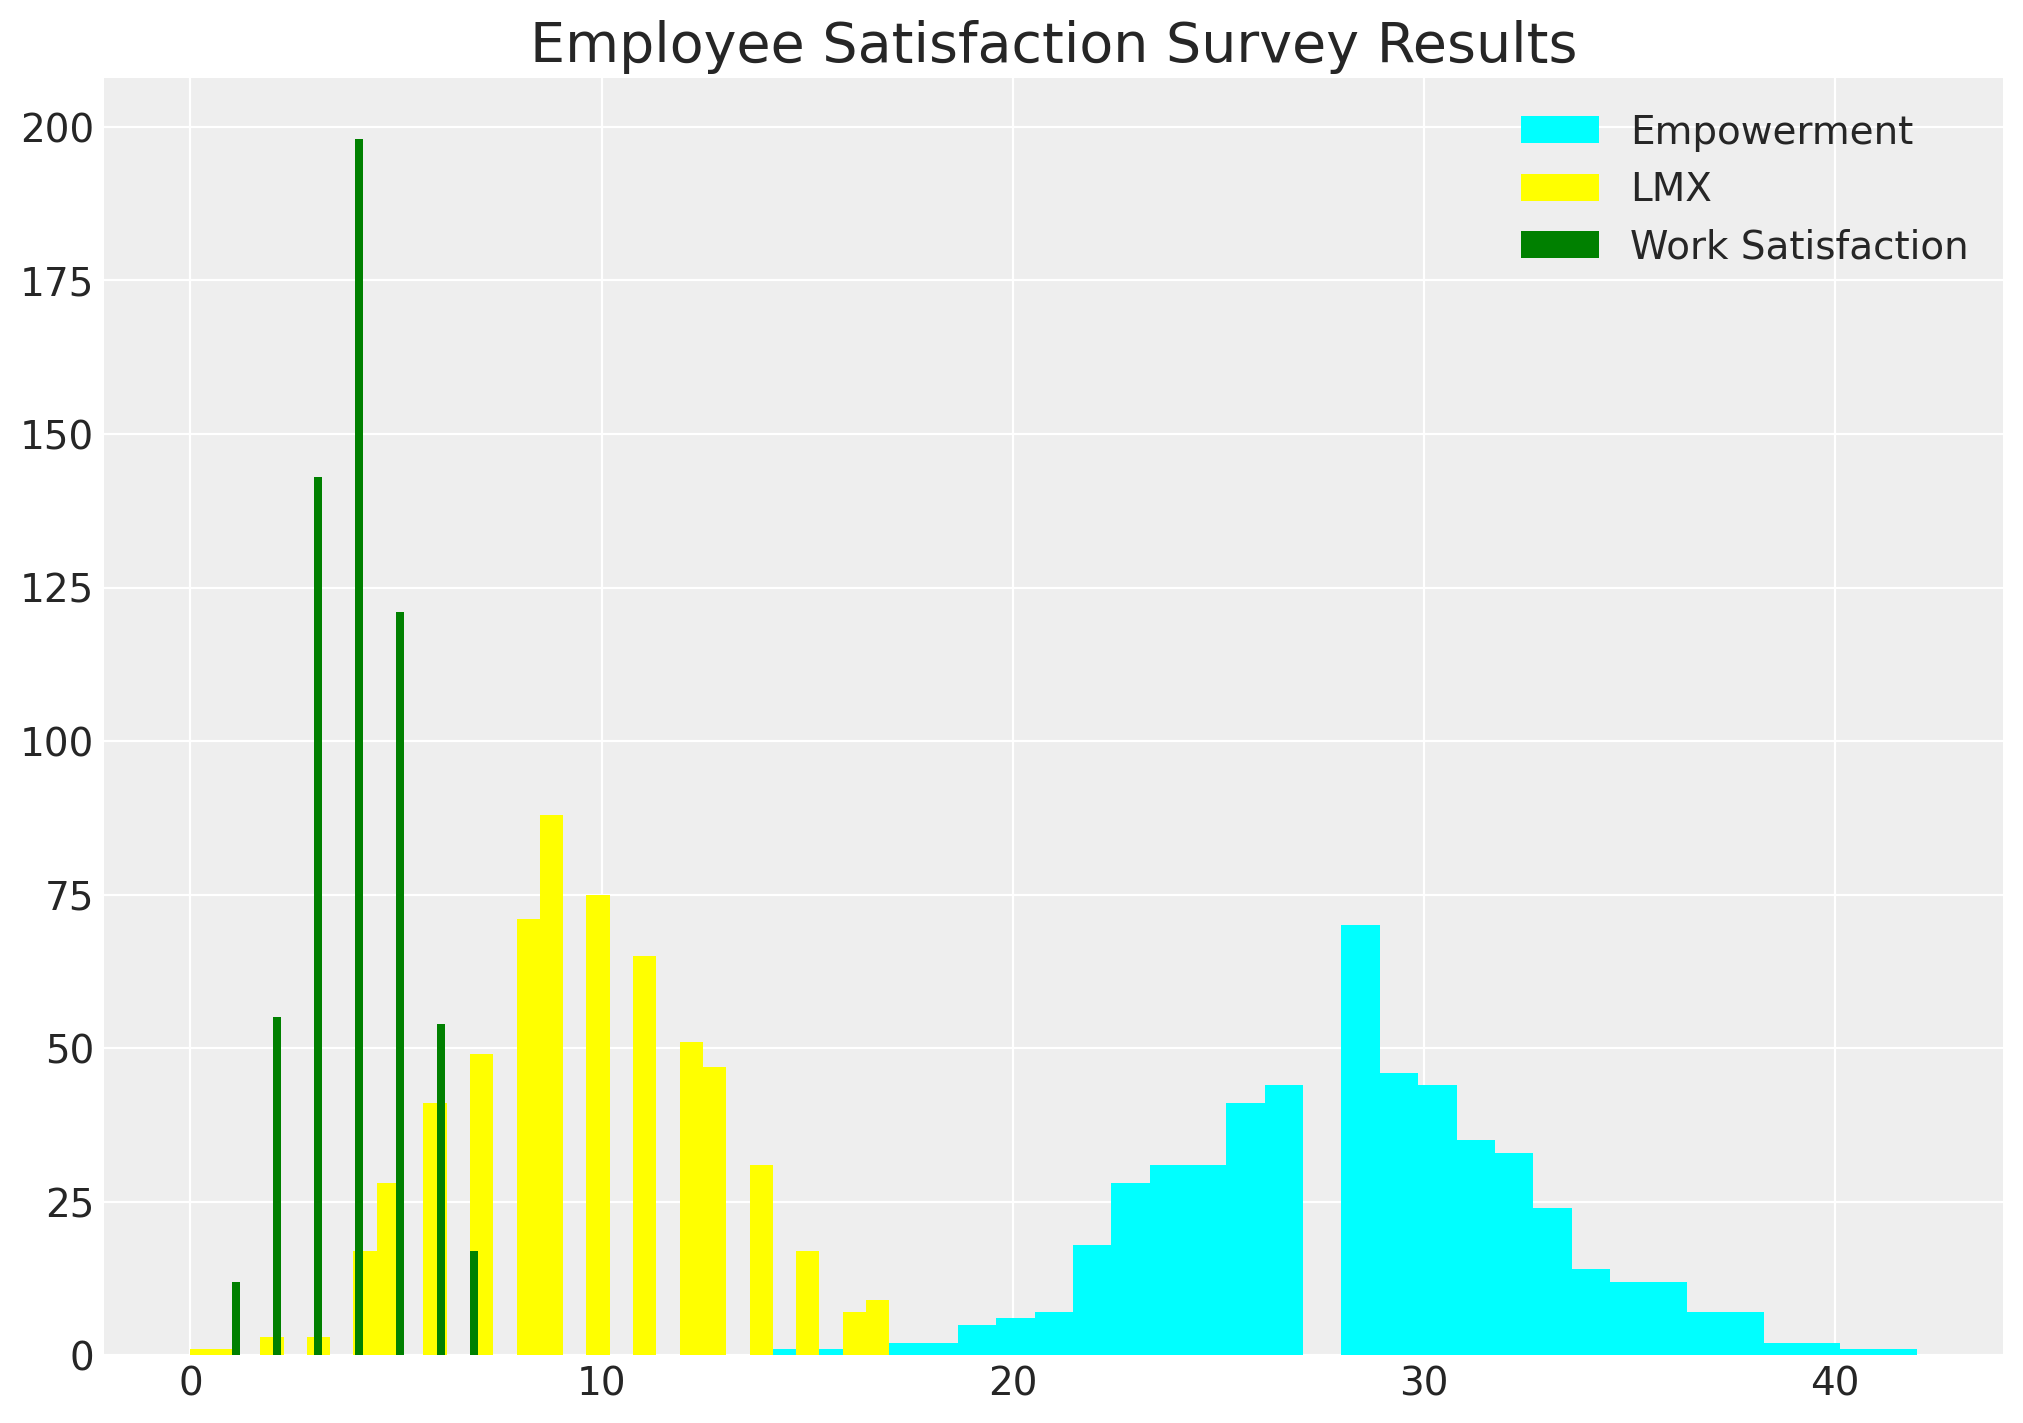

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(df_employee["empower"], bins=30, ec="black", color="cyan", label="Empowerment")
ax.hist(df_employee["lmx"], bins=30, ec="black", color="yellow", label="LMX")
ax.hist(df_employee["worksat"], bins=30, ec="black", color="green", label="Work Satisfaction")
ax.set_title("Employee Satisfaction Survey Results", fontsize=20)
ax.legend();

### FILM

In [ ]:
data = df_employee[["worksat", "empower", "lmx"]]


def split_data_by_missing_pattern(data):
    # We want to extract our the pattern of missing-ness in our dataset
    # and save each sub-set of our data in a structure that can be used to feed into a log-likelihood function
    grouped_patterns = []
    patterns = data.notnull().drop_duplicates().values
    # A pattern is whether the values in each column e.g. [True, True, True] or [True, True, False]
    observed = data.notnull()
    for p in range(len(patterns)):
        temp = observed[
            (observed["worksat"] == patterns[p][0])
            & (observed["empower"] == patterns[p][1])
            & (observed["lmx"] == patterns[p][2])
        ]
        grouped_patterns.append([patterns[p], temp.index, data.iloc[temp.index].dropna(axis=1)])

    return grouped_patterns


def reconstitute_params(params_vector, n_vars):
    # Convenience numpy function to construct mirrored COV matrix
    # From flattened params_vector
    mus = params_vector[0:n_vars]
    cov_flat = params_vector[n_vars:]
    indices = np.tril_indices(n_vars)
    cov = np.empty((n_vars, n_vars))
    for i, j, c in zip(indices[0], indices[1], cov_flat):
        cov[i, j] = c
        cov[j, i] = c
    cov = cov + 1e-25
    return mus, cov


def optimise_ll(flat_params, n_vars, grouped_patterns):
    mus, cov = reconstitute_params(flat_params, n_vars)
    # Check if COV is positive definite
    if (np.linalg.eigvalsh(cov) < 0).any():
        return 1e100
    objval = 0.0
    for obs_pattern, _, obs_data in grouped_patterns:
        # This is the key (tricky) step because we're selecting the variables which pattern
        # the full information set within each pattern of "missing-ness"
        # e.g. when the observed pattern is [True, True, False] we want the first two variables
        # of the mus vector and we want only the covariance relations between the relevant variables from the cov
        # in the iteration.
        obs_mus = mus[obs_pattern]
        obs_cov = cov[obs_pattern][:, obs_pattern]
        ll = np.sum(multivariate_normal(obs_mus, obs_cov).logpdf(obs_data))
        objval = ll + objval
    return -objval


def estimate(data):
    n_vars = data.shape[1]
    # Initialise
    mus0 = np.zeros(n_vars)
    cov0 = np.eye(n_vars)
    # Flatten params for optimiser
    params0 = np.append(mus0, cov0[np.tril_indices(n_vars)])
    # Process Data
    grouped_patterns = split_data_by_missing_pattern(data)
    # Run the Optimiser.
    try:
        result = scipy.optimize.minimize(
            optimise_ll, params0, args=(n_vars, grouped_patterns), method="Powell"
        )
    except Exception as e:
        raise e
    mean, cov = reconstitute_params(result.x, n_vars)
    return mean, cov


fiml_mus, fiml_cov = estimate(data)


print("Full information Maximum Likelihood Estimate Mu:")
display(pd.DataFrame(fiml_mus, index=data.columns).T)
print("Full information Maximum Likelihood Estimate COV:")
pd.DataFrame(fiml_cov, columns=data.columns, index=data.columns)

Full information Maximum Likelihood Estimate Mu:


,worksat,empower,lmx
0,3.983351,28.595211,9.624485


Full information Maximum Likelihood Estimate COV:


,worksat,empower,lmx
worksat,1.568676,1.599817,1.547433
empower,1.599817,19.138522,5.428954
lmx,1.547433,5.428954,8.934030


In [ ]:
mle_fit = multivariate_normal(fiml_mus, fiml_cov)
mle_sample = mle_fit.rvs(630)
mle_sample = pd.DataFrame(mle_sample, columns=["worksat", "empower", "lmx"])
mle_sample.head()

,worksat,empower,lmx
0,5.667335,24.765660,9.296523
1,4.091999,25.937740,9.254906
2,4.355595,31.827698,4.570303
3,5.727332,35.704365,8.425397
4,1.682240,17.011366,4.761044


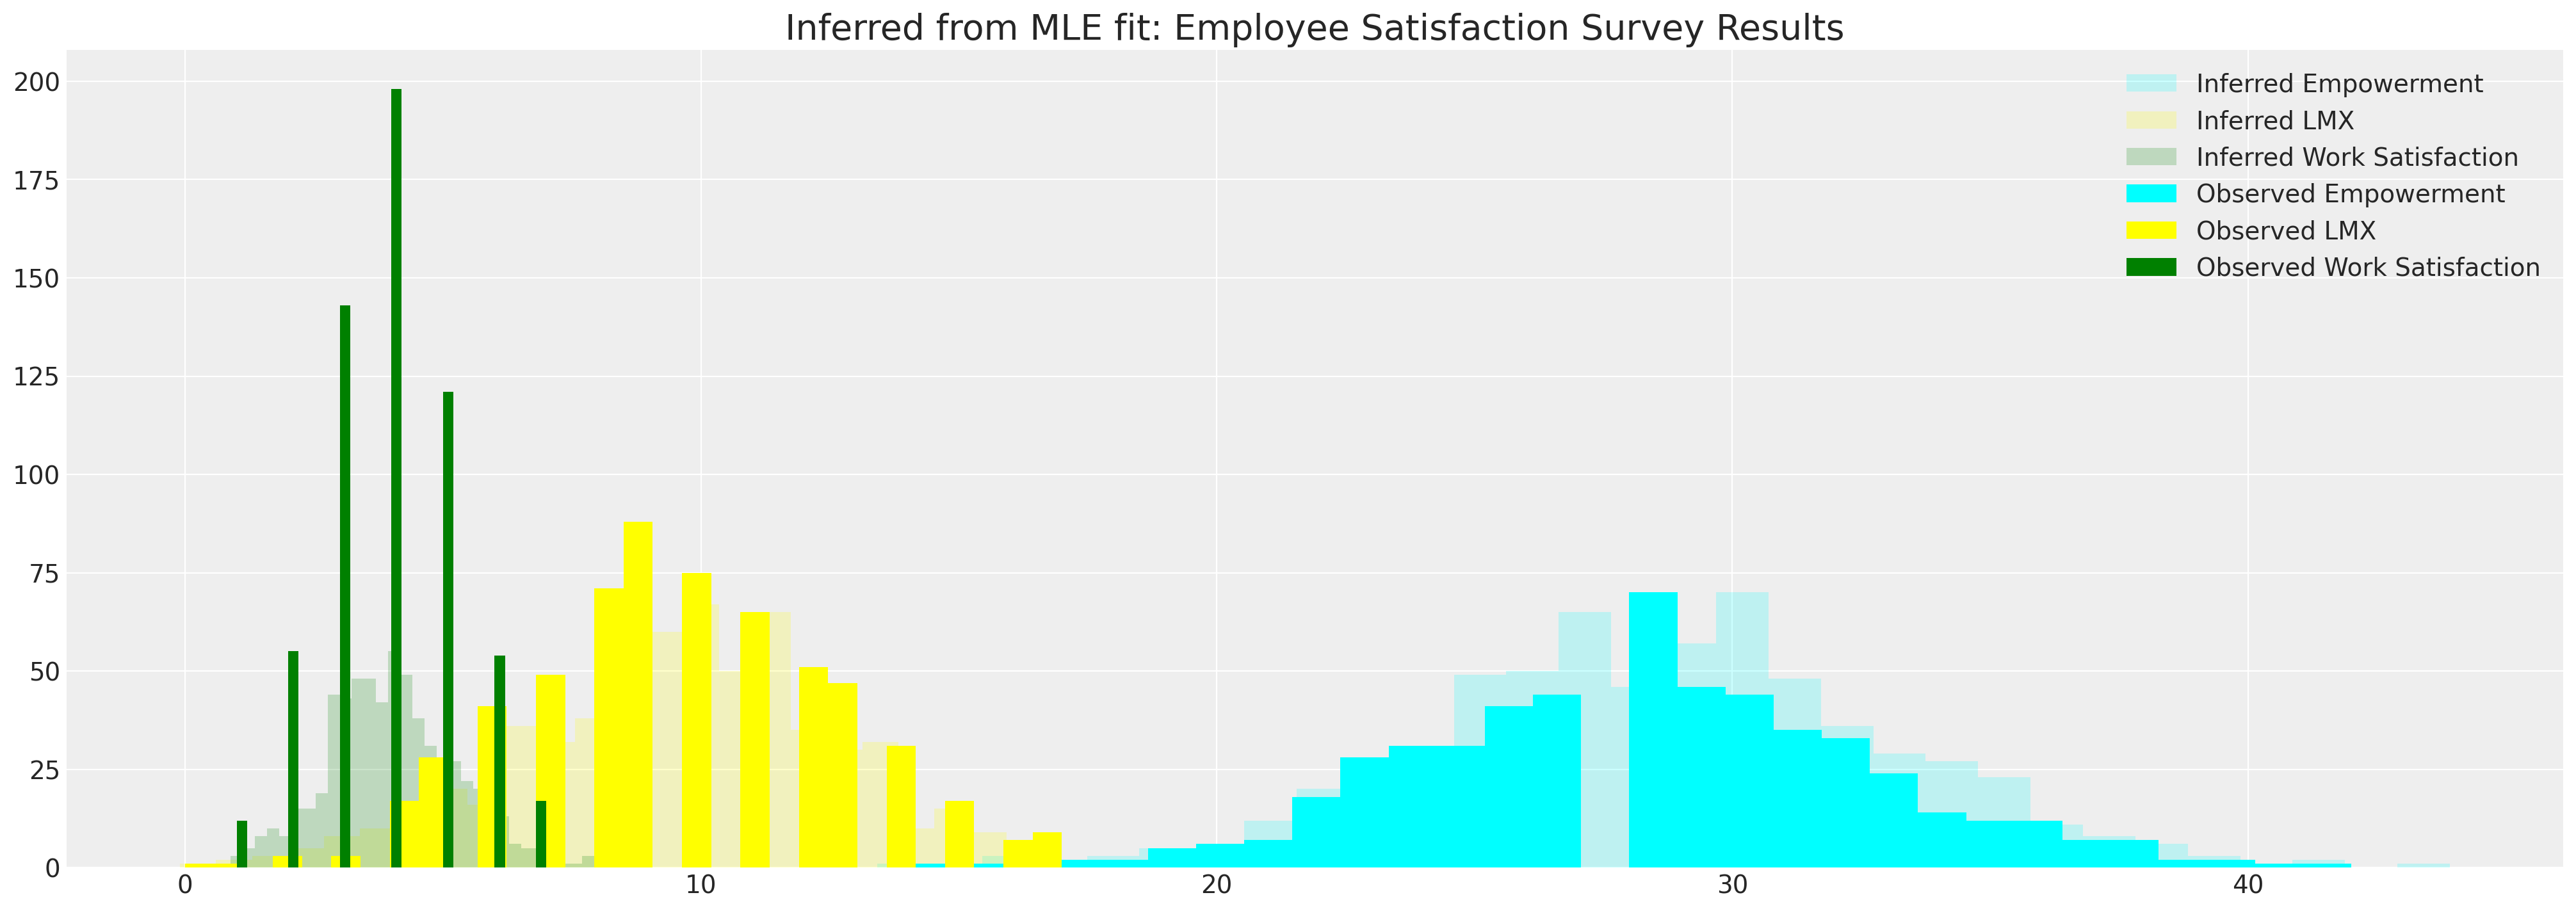

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(
    mle_sample["empower"],
    bins=30,
    ec="black",
    color="cyan",
    alpha=0.2,
    label="Inferred Empowerment",
)
ax.hist(mle_sample["lmx"], bins=30, ec="black", color="yellow", alpha=0.2, label="Inferred LMX")
ax.hist(
    mle_sample["worksat"],
    bins=30,
    ec="black",
    color="green",
    alpha=0.2,
    label="Inferred Work Satisfaction",
)
ax.hist(data["empower"], bins=30, ec="black", color="cyan", label="Observed Empowerment")
ax.hist(data["lmx"], bins=30, ec="black", color="yellow", label="Observed LMX")
ax.hist(data["worksat"], bins=30, ec="black", color="green", label="Observed Work Satisfaction")
ax.set_title("Inferred from MLE fit: Employee Satisfaction Survey Results", fontsize=20)
ax.legend()

In [ ]:
pd.DataFrame(mle_sample.corr(), columns=data.columns, index=data.columns)

,worksat,empower,lmx
worksat,1.000000,0.354488,0.480277
empower,0.354488,1.000000,0.419967
lmx,0.480277,0.419967,1.000000


### Imputación Bayesiana

/tmp/ipython-input-3865616598.py:16: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()


Output()

Output()

/usr/local/lib/python3.12/dist-packages/pytensor/compile/function/types.py:1038: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

/tmp/ipython-input-3865616598.py:19: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(idata, extend_inferencedata=True)


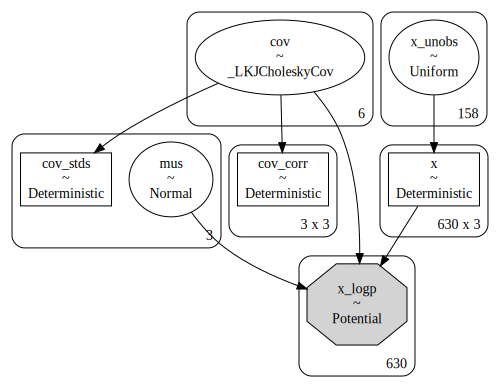

In [ ]:
import pytensor.tensor as pt

with pm.Model() as model:
    # Priors
    mus = pm.Normal("mus", 0, 1, size=3)
    cov_flat_prior, _, _ = pm.LKJCholeskyCov("cov", n=3, eta=1.0, sd_dist=pm.Exponential.dist(1))
    # Create a vector of flat variables for the unobserved components of the MvNormal
    x_unobs = pm.Uniform("x_unobs", 0, 100, shape=(np.isnan(data.values).sum(),))

    # Create the symbolic value of x, combining observed data and unobserved variables
    x = pt.as_tensor(data.values)
    x = pm.Deterministic("x", pt.set_subtensor(x[np.isnan(data.values)], x_unobs))

    # Add a Potential with the logp of the variable conditioned on `x`
    pm.Potential("x_logp", pm.logp(rv=pm.MvNormal.dist(mus, chol=cov_flat_prior), value=x))
    idata = pm.sample_prior_predictive()
    idata = pm.sample()
    idata.extend(pm.sample(random_seed=120))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pm.model_to_graphviz(model)

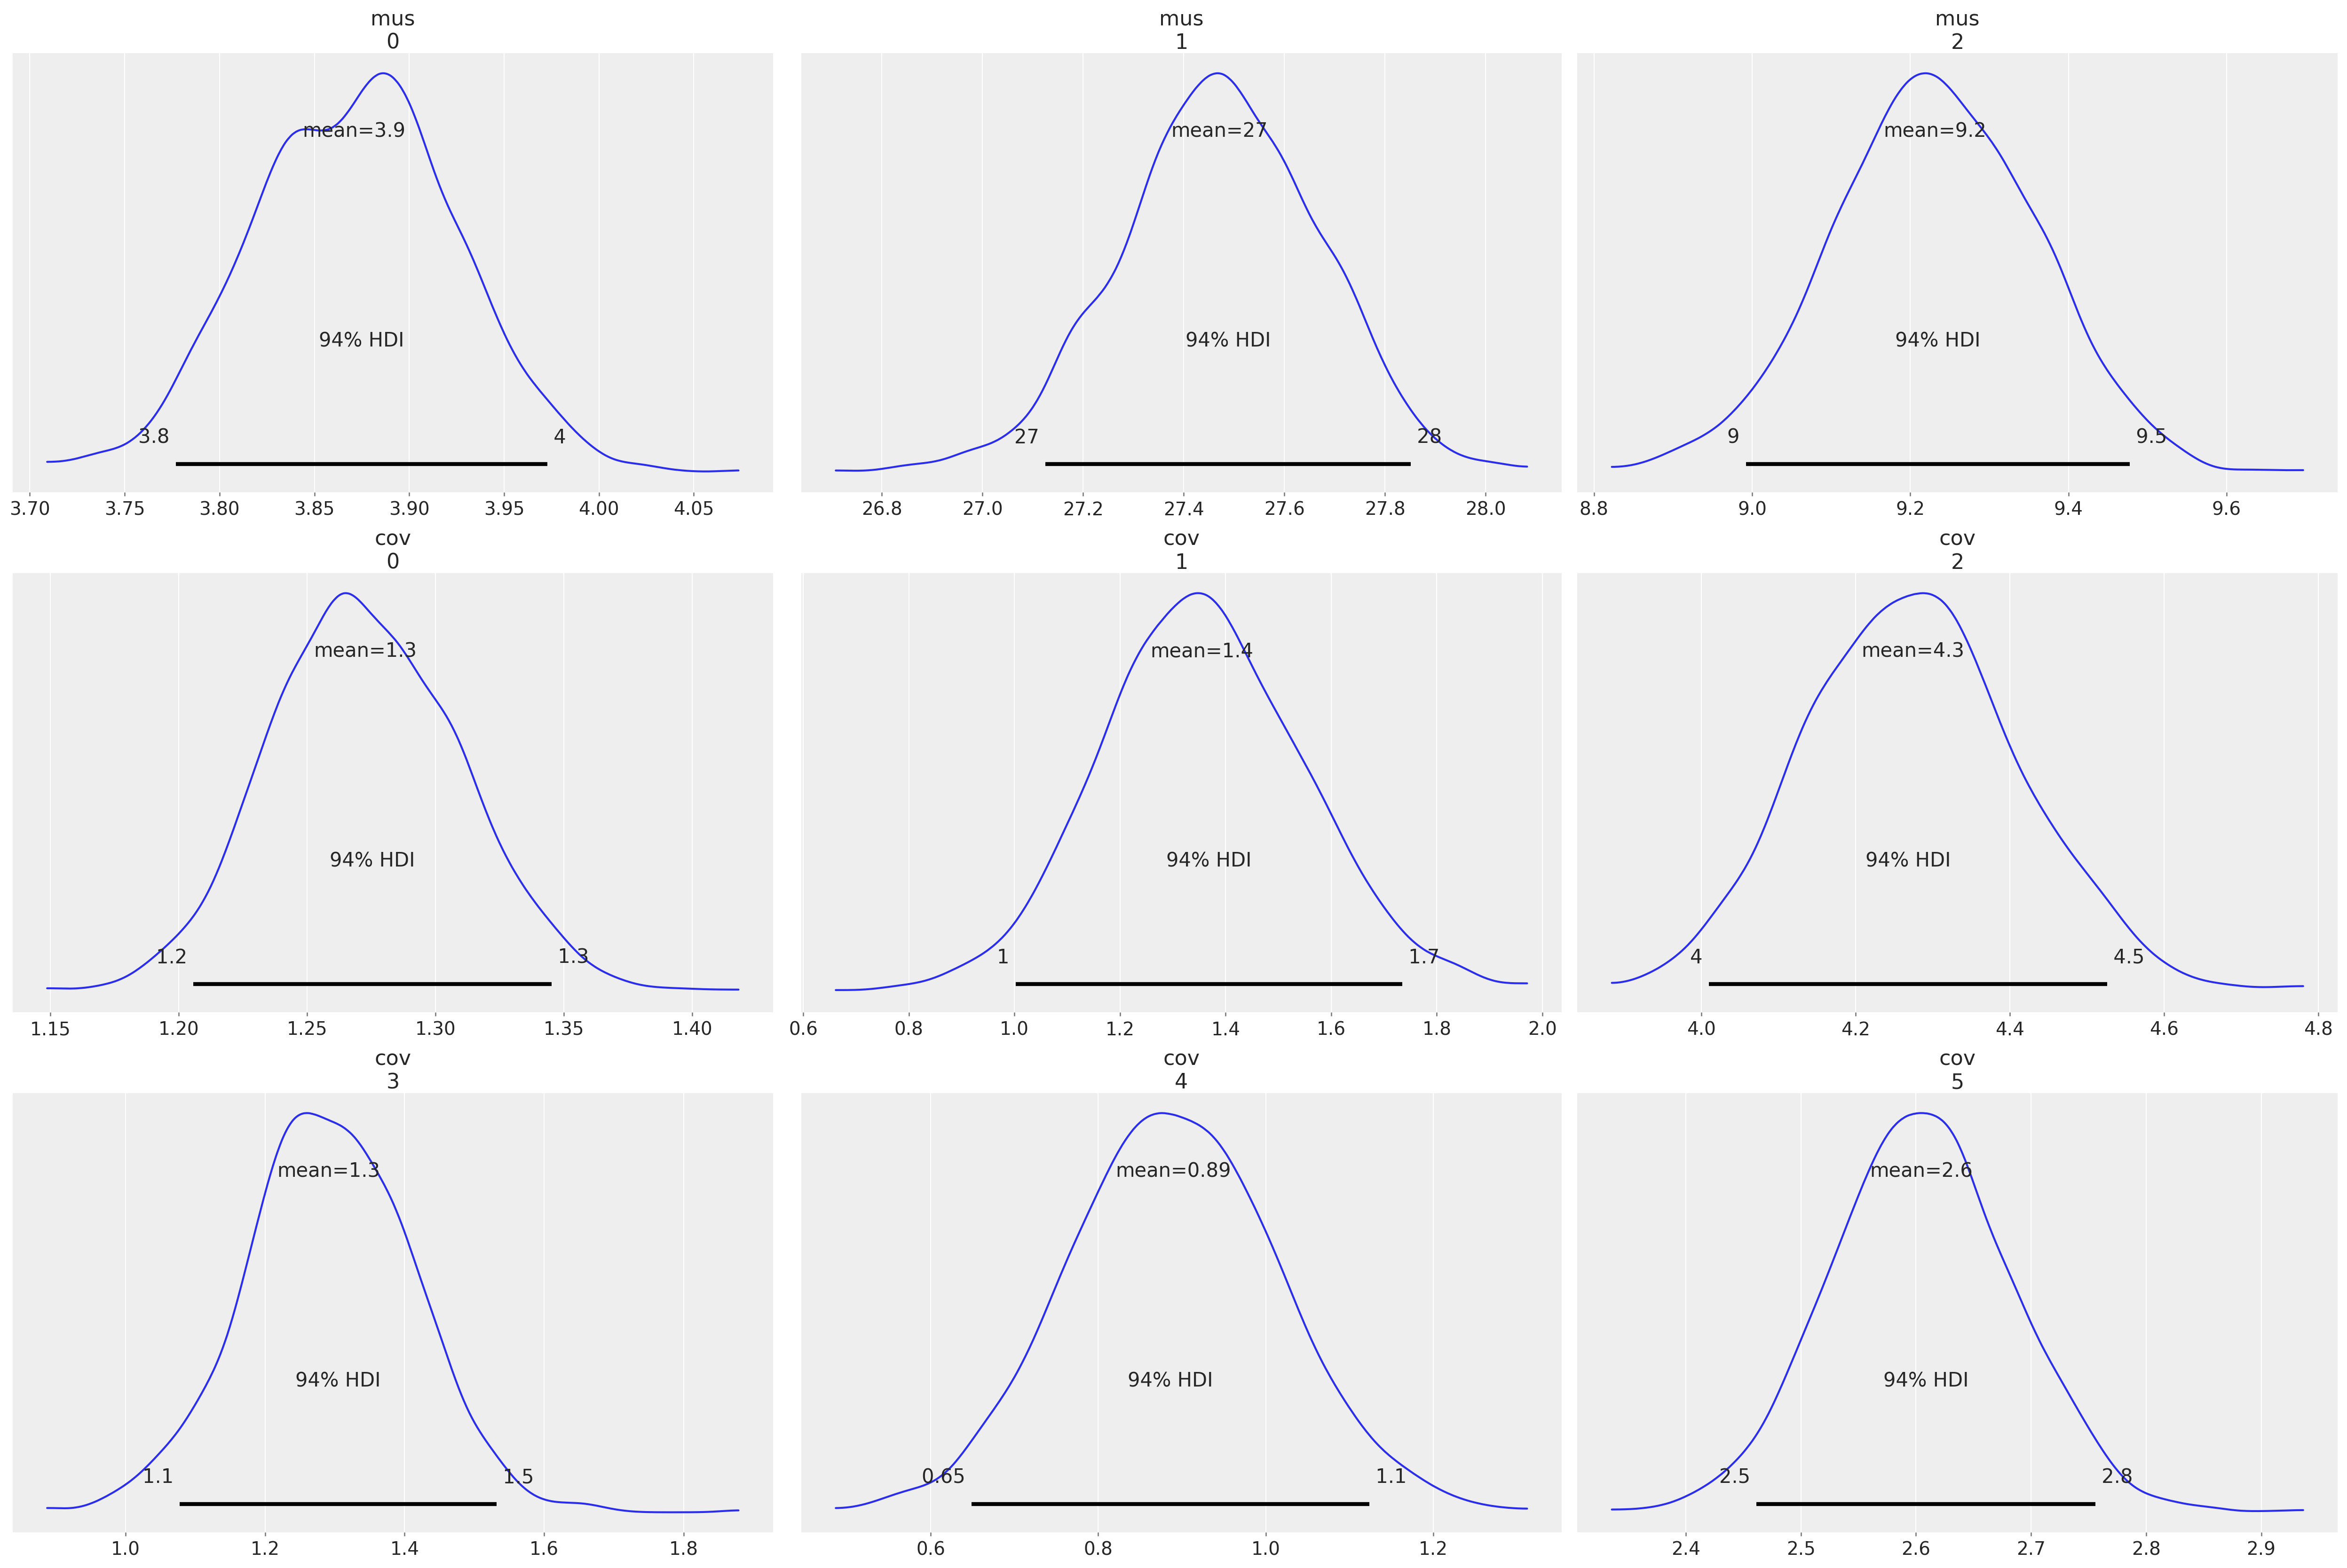

In [ ]:
az.plot_posterior(idata, var_names=["mus", "cov"]);

In [ ]:
imputed_dims = data.shape
imputed = data.values.flatten()
imputed[np.isnan(imputed)] = az.summary(idata, var_names=["x_unobs"])["mean"].values
imputed = imputed.reshape(imputed_dims[0], imputed_dims[1])
imputed = pd.DataFrame(imputed, columns=[col + "_imputed" for col in data.columns])
imputed

,worksat_imputed,empower_imputed,lmx_imputed
0,3.0,32.000,11.0
1,4.0,29.408,13.0
2,4.0,30.000,9.0
3,3.0,29.000,8.0
4,4.0,26.000,7.0
...,...,...,...
625,4.0,28.000,5.0
626,3.0,17.000,5.0
627,4.0,28.000,10.0
628,4.0,27.409,9.0


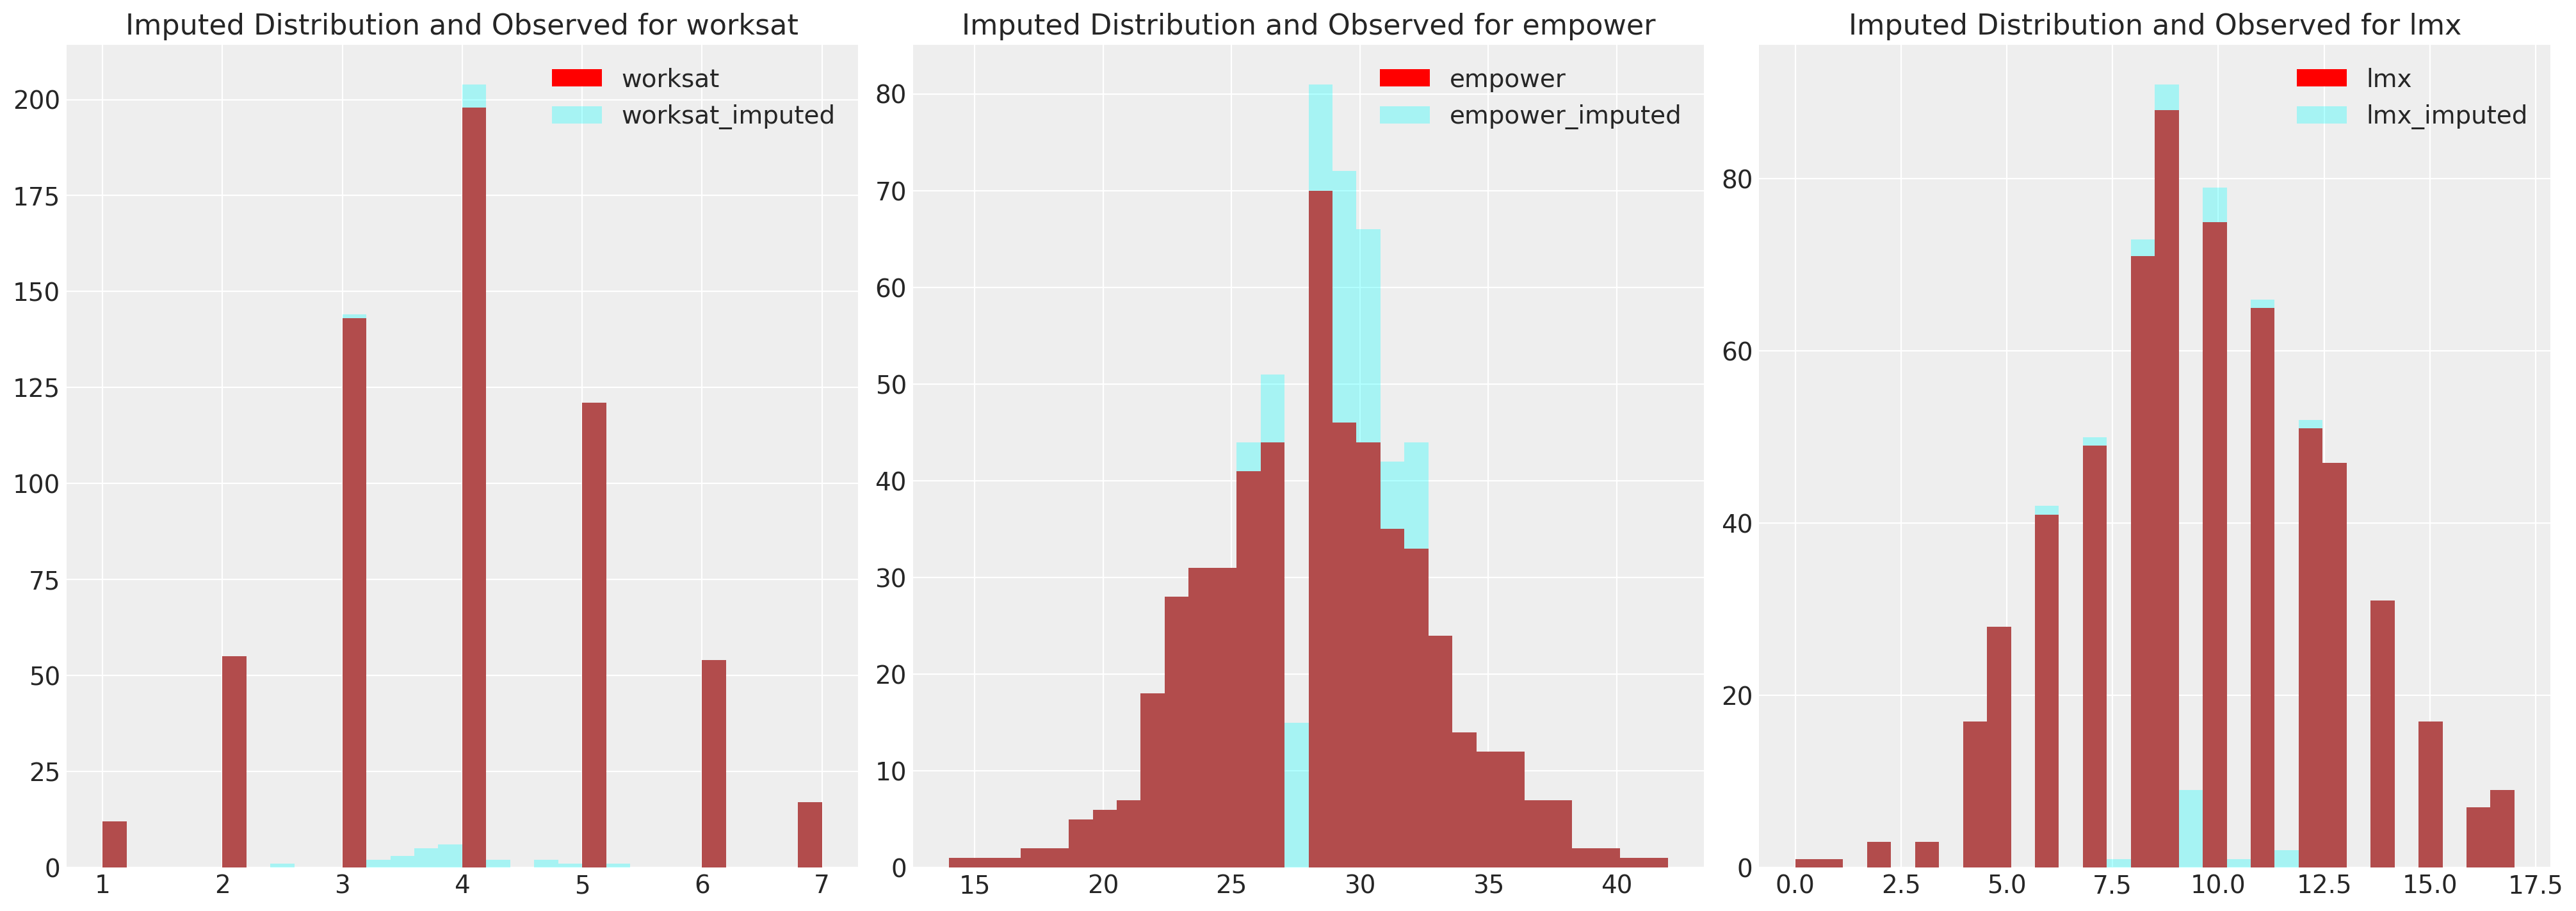

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data.columns, imputed.columns, axs):
    ax.hist(data[col], color="red", label=col, ec="black", bins=30)
    ax.hist(imputed[col_i], color="cyan", alpha=0.3, label=col_i, ec="black", bins=30)
    ax.legend()
    ax.set_title(f"Imputed Distribution and Observed for {col}")